# Models

## Table of Contents
- Load Data
- Sample and Feature Preparation
    - Missing Data
    - One-Hot Encoding
    - Output Encoding
- Train-Test Split
- Utils
- Model Selection
    - RandomForest
        - Hyperparameter Tuning
        - Correlation Between Models
        - Pairwise Comparison of Models
        - Final Model Evaluation
    - LightGBM
        - Hyperparameter Tuning
        - Correlation Between Models
        - Pairwise Comparison of Models
        - Final Model Evaluation
- Final Model
    - Final Model
    - Metrics
    - Model Analysis
    - Feature Importance

In [1]:
import joblib
from copy import deepcopy
from itertools import combinations
import random
from math import factorial
from scipy import stats
from scipy.stats import t
import numpy as np
import pandas as pd

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# utils
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV

# models
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# metrics
from sklearn.metrics import (
    classification_report, 
    f1_score, 
    precision_score, 
    recall_score, 
    confusion_matrix,
) 
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# sns config
sns.set_style("whitegrid")
sns.set_palette("Blues_r")

In [3]:
# plotly config
import plotly.io as pio
pio.renderers.default = "browser"

template = "plotly_white"
colors = {
    "red": "rgb(255,0,0)",
    "dark_blue": "rgb(30,144,255)",
    "medium_blue": "rgb(0,191,255)",
    "light_blue": "rgb(135,206,250)",
    "dark_purple": "rgb(202, 105, 157)",
    "medium_purple": "rgb(221, 136, 172)",
    "light_purple": "rgb(234, 169, 189)",
    "dark_gray": "rgb(169,169,169)",
    "medium_gray": "rgb(192,192,192)",
    "light_gray": "rgb(211,211,211)"
}
title_font_size = 22
font_size = 18

# Load Data

**Note:**
- Keep only features that have predictive value based on the Data Analysis.

In [4]:
df_loans = pd.read_pickle("../data/processed/df_loans.pkl")
df_loans = df_loans[["id", "user_id", "amount_bin", "interest_rate_bin"]]

df_loans

,id,user_id,amount_bin,interest_rate_bin
0,0,3070,6k - 7k,small
1,1,2546,6k - 7k,small
2,2,2413,6k - 7k,small
3,3,2585,6k - 7k,small
4,4,2556,6k - 7k,small
...,...,...,...,...
6741,6741,2130,2k - 3k,large
6742,6742,549,6k - 7k,large
6743,6743,1414,6k - 7k,large
6744,6744,2070,6k - 7k,large


In [5]:
df_loan_repayments = pd.read_pickle("../data/processed/df_loan_repayments.pkl")

df_loan_repayments = df_loan_repayments[["id", "loan_id", "created_at", "amount", "status_cleaned", "days_since_loan_created", 
                                         "days_since_due_date", "due_date_exceeded", "days_lag_repayment", "num_late_repayments", 
                                         'prev_status', "prev_amount", "cumsum_amount", "ratio_repaid_total"]]
df_loan_repayments = df_loan_repayments.rename(columns={"id": "repayment_id", "amount": "repayment_amount"})

df_loan_repayments

,repayment_id,loan_id,created_at,repayment_amount,status_cleaned,days_since_loan_created,days_since_due_date,due_date_exceeded,days_lag_repayment,num_late_repayments,prev_status,prev_amount,cumsum_amount,ratio_repaid_total
50,51,0,2022-02-03,9.75,paid,2,0,0,2.0,0,init,0.00,9.75,0.001613
112,113,0,2022-02-04,45.30,paid,3,0,0,1.0,0,paid,9.75,55.05,0.009106
216,217,0,2022-02-05,25.50,paid,4,0,0,1.0,0,paid,45.30,80.55,0.013324
496,497,0,2022-02-08,10.50,paid,7,0,0,3.0,0,paid,25.50,91.05,0.015061
645,646,0,2022-02-09,226.50,paid,8,0,0,1.0,0,paid,10.50,317.55,0.052529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171446,171447,6745,2022-12-14,6.00,paid,72,0,0,1.0,0,paid,36.00,6387.14,1.056550
171543,171544,6745,2022-12-15,93.00,paid,73,0,0,1.0,0,paid,6.00,6480.14,1.071934
171881,171882,6745,2022-12-20,126.74,paid,78,0,0,5.0,0,paid,93.00,6606.88,1.092899
171963,171964,6745,2022-12-21,203.37,paid,79,0,0,1.0,0,paid,126.74,6810.25,1.126540


In [6]:
df_users = pd.read_pickle("../data/processed/df_users.pkl")

df_users = df_users[["user_id", "median_spending", "avg_intallments", "rate_denied", 
                     "rate_transactions_installment", "rate_credit_debit", "ratio_online_person"]]
df_users["rate_transactions_installment"] = df_users["rate_transactions_installment"].astype(float)

df_users

,user_id,median_spending,avg_intallments,rate_denied,rate_transactions_installment,rate_credit_debit,ratio_online_person
0,1,270.0,4.500000,0.300000,0.700000,4.500000,0.000000
1,2,1130.0,8.257143,0.057143,0.971429,17.000000,0.000000
2,3,1000.0,5.551282,0.115385,1.000000,78.000000,0.012821
3,4,307.5,2.646853,0.090909,0.419580,1.657407,0.003497
4,5,172.0,1.952081,0.083228,0.480454,131.333333,0.000000
...,...,...,...,...,...,...,...
3043,3149,240.0,1.935065,0.069264,0.333333,2.052632,0.004329
3044,3150,105.0,1.618375,0.174323,0.398115,2.586498,0.289833
3045,3151,207.0,2.687225,0.092511,0.568282,2.257143,0.017857
3046,3152,240.1,3.213775,0.135063,0.952594,61.166667,0.028493


In [7]:
df_users_segments = pd.read_pickle("../data/processed/df_users_segments.pkl")

df_users_segments

,user_id,rfm_segment_desc
0,1,Inactive
1,2,Inactive
2,3,Inactive
3,4,Promising
4,5,Promising
...,...,...
3043,3149,Inactive
3044,3150,Champions
3045,3151,Inactive
3046,3152,Promising


# Sample and Feature Preparation

- Missing Data
- One-Hot Encoding
- Output Encoding

In [8]:
# merge tables
df_users = df_users.merge(df_users_segments, how="left", on="user_id")
df_loans_users = df_loans.merge(df_users, how="left", on="user_id").rename(columns={"id": "loan_id"})
df_data = df_loan_repayments.merge(df_loans_users, how="left", on="loan_id")

In [9]:
# sort by loan_id and repayment date (ascending)
df_data = df_data.sort_values(by=["loan_id", "created_at"])

In [10]:
df_data = df_data.drop(columns=["created_at", "user_id"]) 

## Missing Data

**Note:**
- New users being evaluated
    - New users, for which we don't have yet the transaction history to calculate the relevant features, are being defaulted to the RFM customer segment `Recent`.
    - The features for these users are calculated according to the statistics of the RFM segment `Recent`. For example, rate of denied transactions is based on the median of the segment `Recent` (similarly for the rest of the user derived features).

In [11]:
df_data.loc[df_data["rfm_segment_desc"].isna(), "rfm_segment_desc"] = "Recent"

# input missing values for user-related features by taking values 
# (median here) that are related to Recent customers' behavior
df_data.loc[df_data["ratio_online_person"].isna(), "ratio_online_person"] = df_data[df_data["rfm_segment_desc"] == "Recent"]["ratio_online_person"].median()
df_data.loc[df_data["rate_credit_debit"].isna(), "rate_credit_debit"] = df_data[df_data["rfm_segment_desc"] == "Recent"]["rate_credit_debit"].median()
df_data.loc[df_data["rate_transactions_installment"].isna(), "rate_transactions_installment"] = df_data[df_data["rfm_segment_desc"] == "Recent"]["rate_transactions_installment"].median()
df_data.loc[df_data["rate_denied"].isna(), "rate_denied"] = df_data[df_data["rfm_segment_desc"] == "Recent"]["rate_denied"].median()
df_data.loc[df_data["avg_intallments"].isna(), "avg_intallments"] = df_data[df_data["rfm_segment_desc"] == "Recent"]["avg_intallments"].median()
df_data.loc[df_data["median_spending"].isna(), "median_spending"] = df_data[df_data["rfm_segment_desc"] == "Recent"]["median_spending"].median()

## One-Hot Encoding

In [12]:
df_data = pd.concat([df_data, pd.get_dummies(df_data["prev_status"], prefix='prev_status')], axis=1)
df_data = df_data.drop(['prev_status'], axis=1)

In [13]:
df_data = pd.concat([df_data, pd.get_dummies(df_data["amount_bin"], prefix='amount_bin')], axis=1)
df_data = df_data.drop(['amount_bin'], axis=1)

In [15]:
df_data = pd.concat([df_data, pd.get_dummies(df_data["interest_rate_bin"], prefix='interest_rate_bin')], axis=1)
df_data = df_data.drop(['interest_rate_bin'], axis=1)

In [16]:
df_data = pd.concat([df_data, pd.get_dummies(df_data["rfm_segment_desc"], prefix='rfm_segment')], axis=1)
df_data = df_data.drop(['rfm_segment_desc'], axis=1)

## Output Encoding

In [17]:
mapping = {
    "paid": 0,
    "defaulted": 1,
}
df_data["status_cleaned"] = df_data["status_cleaned"].replace(mapping)

# Train-Test Split

In [18]:
def custom_train_test_split(
    data: pd.DataFrame, 
    primary_key: str, 
    output_key: str, 
    split_key: str, 
    test_size: float, 
    random_state: int,
) -> tuple:
    """ Split multiple time-series data into random train and test subsets.

    The objective is for a time-series to belong only on the train/test set and not in both, so that there is no data leakage.

    Args:
        data:
            Input datataset.
        primary_key:
            Primary key of the dataset.
        output_key:
            Target variable key.
        split_key:
            Key to split the data into train/test.
        test_size:
            Proportion of the dataset to include in the test split
        random_state:
            Controls the shuffling applied to the data before applying the split.
    
    Returns:
        Train and test set features and target.
    """
    train_ids, test_ids = train_test_split(list(set(data[split_key])), test_size=test_size, random_state=random_state)

    train, test = df_data[df_data[split_key].isin(train_ids)], df_data[df_data[split_key].isin(test_ids)]

    X_train, y_train = train.loc[:, ~train.columns.isin([primary_key, output_key])], train.loc[:, train.columns == output_key]
    X_test, y_test = test.loc[:, ~test.columns.isin([primary_key, output_key])], test.loc[:, test.columns == output_key]

    return X_train, y_train, X_test, y_test

In [19]:
X_train, y_train, X_test, y_test = custom_train_test_split(
    df_data, 
    primary_key="repayment_id", 
    output_key="status_cleaned", 
    split_key="loan_id", 
    test_size=0.2, 
    random_state=42
)

In [20]:
print(f"Train: number of loans: {X_train['loan_id'].unique().shape[0]:,}\nTest: number of loans: {X_test['loan_id'].unique().shape[0]:,}")

Train: number of loans: 5,278
Test: number of loans: 1,320


In [21]:
print(f"Train: number of loan repayments: {X_train.shape[0]:,}\nTest: number of loan repayments: {X_test.shape[0]:,}")

Train: number of loan repayments: 138,204
Test: number of loan repayments: 34,241


In [22]:
paid, defaulted = y_train[y_train["status_cleaned"] == 0].shape[0], y_train[y_train["status_cleaned"] == 1].shape[0]
print(f"Train:\n\tnumber of paid repayments: {paid:,}\n\tnumber of defaulted repayments: {defaulted:,}")

paid, defaulted = y_test[y_test["status_cleaned"] == 0].shape[0], y_test[y_test["status_cleaned"] == 1].shape[0]
print(f"Test:\n\tnumber of paid repayments: {paid:,}\n\tnumber of defaulted repayments: {defaulted:,}")

Train:
	number of paid repayments: 131,220
	number of defaulted repayments: 6,984
Test:
	number of paid repayments: 32,485
	number of defaulted repayments: 1,756


In [23]:
X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)

# Utils

In [24]:
def corrected_std(differences, n_train, n_test):
    """ Corrects standard deviation using Nadeau and Bengio's approach.

    Parameters:
        differences:
            Vector containing the differences in the score metrics of two models.
        n_train:
            Number of samples in the training set.
        n_test:
            Number of samples in the testing set.

    Returns:
        corrected_std:
            Variance-corrected standard deviation of the set of differences.
    """
    kr = len(differences)  # number of times the model was evaluated
    corrected_var = np.var(differences, ddof=1) * (1 / kr + n_test / n_train)
    corrected_std = np.sqrt(corrected_var)
    return corrected_std

In [25]:
def compute_corrected_ttest(differences, df, n_train, n_test):
    """ Computes right-tailed paired t-test with corrected variance.

    Parameters:
        differences:
            Vector containing the differences in the score metrics of two models.
        df:
            Degrees of freedom.
        n_train:
            Number of samples in the training set.
        n_test:
            Number of samples in the testing set.

    Returns:
        t_stat:
            Variance-corrected t-statistic.
        p_val:
            Variance-corrected p-value.
    """
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = t.sf(np.abs(t_stat), df)  # right-tailed t-test
    return t_stat, p_val

In [26]:
def k_fold(X: pd.DataFrame, primary_key: str, folds: int) -> list:
    """ K-Fold cross-validator for multiple time-series data.

    Provides train/test indices to split data in train/test sets, based on the time-series primary key.
    The objective is for a time-series to belong only on the train/test set and not in both, so that there is no data leakage.
    
    Splits dataset into k consecutive folds with shuffling.

    Args:
        X:
            Training data.
        primary_key:
            Primary key of the multiple time-series.
        folds:
            Number of folds.
    
    Returns:
        List of indices to split data into training and test set, per fold.
    """
    ids = list(set(X[primary_key]))
    random.shuffle(ids)

    fold_ids = np.array_split(ids, folds)

    cv = []
    for fold in range(folds):
        train_ids = fold_ids[fold].tolist()
        test_ids = []
        for i in range(folds):
            if i != fold:
                test_ids.extend(fold_ids[i].tolist())
                
        train_indexes = X_train[X_train[primary_key].isin(train_ids)].index.values
        test_indexes = X_train[X_train[primary_key].isin(test_ids)].index.values
        cv.append((train_indexes, test_indexes))
        
    return cv

In [27]:
folds = 10

cv = k_fold(X_train, primary_key="loan_id", folds=10)

In [28]:
X_train_aux, X_test_aux = X_train.drop(columns=["loan_id"]), X_test.drop(columns=["loan_id"])

# Model Selection

In [30]:
labels = ["paid", "defaulted"]

## Random Forest

### Hyperparameter Tuning

---

**Best search parameters:** n_estimators: 450, max_depth: 10, class_weight: balanced_subsample

In [43]:
pipe = Pipeline([
    ('clf', RandomForestClassifier(random_state=42))
])

# hyperparameter space
parameters = {
    'clf__n_estimators': list(range(50, 550, 50)),
    'clf__max_depth': list(range(5, 55, 5)) + [None],
    'clf__class_weight': ["balanced", "balanced_subsample"]
}

In [ ]:
# hyperparameter tuning
search = BayesSearchCV(
    pipe,
    parameters,
    n_iter=60,
    scoring=["f1_weighted", "precision_weighted", "recall_weighted"],
    refit="f1_weighted",
    cv=cv,
    return_train_score=True,
    random_state=42,
    verbose=10
)

search.fit(X_train_aux, np.ravel(y_train))

In [46]:
print(f'Best search train weighted F1-score: {search.cv_results_["mean_train_f1_weighted"][search.best_index_]:,.2f}')
print(f'Best search eval weighted F1-score: {search.cv_results_["mean_test_f1_weighted"][search.best_index_]:,.2f}\n')

print(f'Best search train weighted Precision: {search.cv_results_["mean_train_precision_weighted"][search.best_index_]:.2f}')
print(f'Best search eval weighted Precision: {search.cv_results_["mean_test_precision_weighted"][search.best_index_]:.2f}\n')

print(f'Best search train weighted Recall: {search.cv_results_["mean_train_recall_weighted"][search.best_index_]:.2f}')
print(f'Best search eval weighted Recall: {search.cv_results_["mean_test_recall_weighted"][search.best_index_]:.2f}\n')

print(f'Best search parameters:\n{search.best_params_}')

Best search train weighted F1-score: 0.97
Best search eval weighted F1-score: 0.95

Best search train weighted Precision: 0.97
Best search eval weighted Precision: 0.95

Best search train weighted Recall: 0.97
Best search eval weighted Recall: 0.95

Best search parameters:
OrderedDict([('clf__class_weight', 'balanced_subsample'), ('clf__max_depth', 10), ('clf__n_estimators', 450)])


### Correlation Between Models

We can observe tha **tthe performance of the models highly depends on the fold**.

As a consequence, if we assume independence between samples we will be underestimating the variance computed in our statistical tests, increasing the number of false positive errors (i.e. detecting a significant difference between models when such does not exist)

In [47]:
df_results = pd.DataFrame(search.cv_results_).sort_values(by=["rank_test_f1_weighted"])
df_results = df_results.set_index(
    df_results["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("iter")
df_results[["params", "rank_test_f1_weighted", "mean_train_f1_weighted", "mean_test_f1_weighted", 
            "rank_test_precision_weighted", "mean_train_precision_weighted", "mean_test_precision_weighted", 
            "rank_test_recall_weighted", "mean_train_recall_weighted", "mean_test_recall_weighted"]].head(3)

,params,rank_test_f1_weighted,mean_train_f1_weighted,mean_test_f1_weighted,rank_test_precision_weighted,mean_train_precision_weighted,mean_test_precision_weighted,rank_test_recall_weighted,mean_train_recall_weighted,mean_test_recall_weighted
iter,,,,,,,,,,
balanced_subsample_10_450,"{'clf__class_weight': 'balanced_subsample', 'c...",1,0.966724,0.949097,35,0.966807,0.947425,43,0.966786,0.951229
balanced_10_500,"{'clf__class_weight': 'balanced', 'clf__max_de...",2,0.966728,0.949078,40,0.966827,0.947386,42,0.966773,0.951239
balanced_10_300,"{'clf__class_weight': 'balanced', 'clf__max_de...",3,0.966569,0.949063,36,0.966704,0.947405,46,0.966595,0.951160


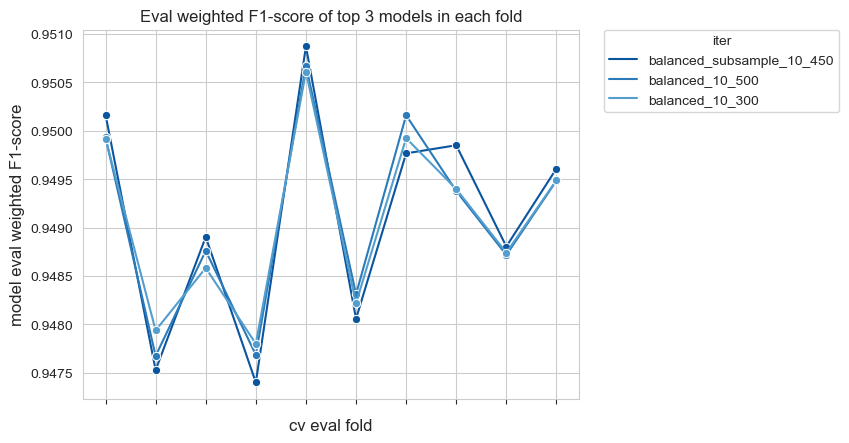

In [48]:
# model scores ordered by performance
model_f1 = df_results.filter(regex=r"split\d*_test_f1_weighted").iloc[:3]

fig, ax = plt.subplots()

sns.lineplot(
    data=model_f1.transpose(),
    dashes=False,
    marker="o",
    ax=ax,
)

ax.set_title('Eval weighted F1-score of top 3 models in each fold')
ax.set_xlabel("cv eval fold", size=12, labelpad=10)
ax.set_ylabel("model eval weighted F1-score", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.legend(title='iter', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [49]:
# correlation of weighted F1-score across folds
print(f"Correlation of models based on weighted F1-score:\n")
model_f1.transpose().corr()

Correlation of models based on weighted F1-score:



iter,balanced_subsample_10_450,balanced_10_500,balanced_10_300
iter,,,
balanced_subsample_10_450,1.000000,0.976082,0.97915
balanced_10_500,0.976082,1.000000,0.99266
balanced_10_300,0.979150,0.992660,1.00000


### Pairwise Comparison of Models

[Frequentist Approach](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html#): Run a paired t-test and compute the p-value.

We observe that the models **don't significantly differ** from each other, thus we can select the proposed model from hyperaparameter tuning.

In [50]:
# pairwise comparison of models based on weighted F1-score

n_train = len(cv[0][0])
n_test = len(cv[0][1])

n_comparisons = factorial(len(model_f1)) / (factorial(2) * factorial(len(model_f1) - 2))
pairwise_t_test = []

for model_i, model_k in combinations(range(len(model_f1)), 2):
    model_i_scores = model_f1.iloc[model_i].values
    model_k_scores = model_f1.iloc[model_k].values
    differences = model_i_scores - model_k_scores
    n = differences.shape[0]  # number of test sets
    df = n - 1
    t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
    p_val *= n_comparisons  # Bonferroni correction
    p_val = 1 if p_val > 1 else p_val  # Bonferroni can output p-values higher than 1
    pairwise_t_test.append([model_f1.index[model_i], model_f1.index[model_k], t_stat, p_val])

pairwise_comp_df = pd.DataFrame(pairwise_t_test, 
                                columns=["model_1", "model_2", "t_stat", "p_val"]).round(3)
pairwise_comp_df

,model_1,model_2,t_stat,p_val
0,balanced_subsample_10_450,balanced_10_500,0.022,1
1,balanced_subsample_10_450,balanced_10_300,0.037,1
2,balanced_10_500,balanced_10_300,0.036,1


### Final Model Evaluation

---

**Best model parameters:**  n_estimators: 450, max_depth: 10, class_weight: balanced_subsample

---

**Best model train weighted F1-score:** 94%
- class paid: 97%
- class defaulted: 50%

**Best model eval weighted F1-score:** 94%
- class paid: 97%
- class defaulted: 47%

---

**Best model train weighted Precision:** 95%
- class paid: 98%
- class defaulted: 42%

**Best model eval weighted Precision:** 95%
- class paid: 98%
- class defaulted: 39%

---

**Best model train weighted Recall:** 94%

**Best model eval weighted Recall:** 94%

---

**Conclusion:** Regarding the defaulted payments, the model grossly underperforms in terms of F1-score and Precison. 

In [51]:
X_temp, y_temp, X_eval, y_eval = custom_train_test_split(
    pd.concat([X_train, y_train], axis=1), 
    primary_key="repayment_id", 
    output_key="status_cleaned", 
    split_key="loan_id", 
    test_size=0.2, 
    random_state=42
)

X_temp, X_eval = X_temp.drop(columns=["loan_id"]), X_eval.drop(columns=["loan_id"])

In [ ]:
clf = RandomForestClassifier(
    n_estimators=450,
    max_depth=10,
    class_weight= 'balanced_subsample',
    random_state=42
)

clf.fit(X_temp, np.ravel(y_temp))

y_train_pred = clf.predict(X_temp)
y_eval_pred = clf.predict(X_eval)

In [55]:
print(f"Train:\n{classification_report(y_temp, y_train_pred, target_names=labels)}")
print(f"Eval:\n{classification_report(y_eval, y_eval_pred, target_names=labels)}")

Train:
              precision    recall  f1-score   support

        paid       0.98      0.95      0.97    106152
   defaulted       0.42      0.62      0.50      5720

    accuracy                           0.94    111872
   macro avg       0.70      0.79      0.73    111872
weighted avg       0.95      0.94      0.94    111872

Eval:
              precision    recall  f1-score   support

        paid       0.98      0.95      0.97     25068
   defaulted       0.39      0.58      0.47      1264

    accuracy                           0.94     26332
   macro avg       0.68      0.77      0.72     26332
weighted avg       0.95      0.94      0.94     26332



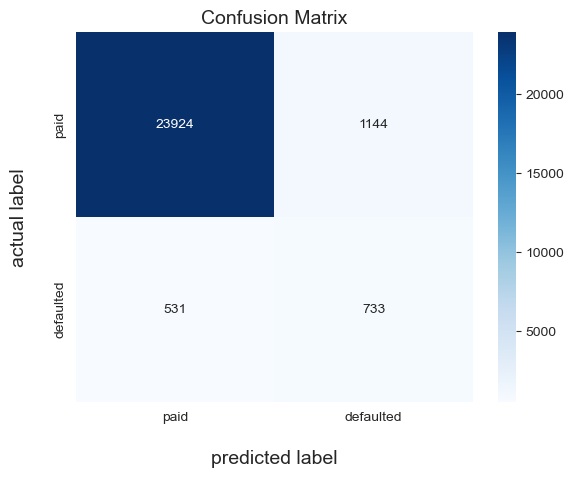

In [56]:
cm = confusion_matrix(y_eval, y_eval_pred)

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix', fontsize=14)
plt.xlabel("\npredicted label", fontsize=14)
plt.ylabel("actual label\n", fontsize=14)

plt.show()

## LightGBM

### Hyperparameter Tuning

---

**Best search parameters:** n_estimators: 500, max_depth: 15, learning_rate: 0.01, colsample_bytree: 1.0, booster: 'gbdt'

In [30]:
pipe = Pipeline([
    ('clf', LGBMClassifier(random_state=42))
])

# hyperparameter space
parameters = {
    'clf__n_estimators': list(range(50, 550, 50)),
    'clf__max_depth': list(range(5, 55, 5)),
    'clf__colsample_bytree': [.4, .5, .6, .8, 1],
    'clf__learning_rate': [1, 1e-1, 1e-2, 1e-3],
    'clf__boosting_type': ['gbdt', 'dart']
}

In [ ]:
# hyperparameter tuning
search = BayesSearchCV(
    pipe,
    parameters,
    n_iter=60,
    scoring=["f1_weighted", "precision_weighted", "recall_weighted"],
    refit="f1_weighted",
    cv=cv,
    return_train_score=True,
    random_state=42,
    verbose=10
)

search.fit(X_train_aux, np.ravel(y_train))

In [32]:
print(f'Best search train weighted F1-score: {search.cv_results_["mean_train_f1_weighted"][search.best_index_]:,.2f}')
print(f'Best search eval weighted F1-score: {search.cv_results_["mean_test_f1_weighted"][search.best_index_]:,.2f}\n')

print(f'Best search train weighted Precision: {search.cv_results_["mean_train_precision_weighted"][search.best_index_]:.2f}')
print(f'Best search eval weighted Precision: {search.cv_results_["mean_test_precision_weighted"][search.best_index_]:.2f}\n')

print(f'Best search train weighted Recall: {search.cv_results_["mean_train_recall_weighted"][search.best_index_]:.2f}')
print(f'Best search eval weighted Recall: {search.cv_results_["mean_test_recall_weighted"][search.best_index_]:.2f}\n')

print(f'Best search parameters:\n{search.best_params_}')

Best search train weighted F1-score: 0.97
Best search eval weighted F1-score: 0.95

Best search train weighted Precision: 0.97
Best search eval weighted Precision: 0.96

Best search train weighted Recall: 0.97
Best search eval weighted Recall: 0.96

Best search parameters:
OrderedDict([('clf__boosting_type', 'gbdt'), ('clf__colsample_bytree', 1), ('clf__learning_rate', 0.01), ('clf__max_depth', 15), ('clf__n_estimators', 500)])


### Correlation Between Models

We can observe tha **tthe performance of the models highly depends on the fold**.

As a consequence, if we assume independence between samples we will be underestimating the variance computed in our statistical tests, increasing the number of false positive errors (i.e. detecting a significant difference between models when such does not exist)

In [33]:
df_results = pd.DataFrame(search.cv_results_).sort_values(by=["rank_test_f1_weighted"])
df_results = df_results.set_index(
    df_results["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("iter")
df_results[["params", "rank_test_f1_weighted", "mean_train_f1_weighted", "mean_test_f1_weighted", 
            "rank_test_precision_weighted", "mean_train_precision_weighted", "mean_test_precision_weighted", 
            "rank_test_recall_weighted", "mean_train_recall_weighted", "mean_test_recall_weighted"]].head(3)

,params,rank_test_f1_weighted,mean_train_f1_weighted,mean_test_f1_weighted,rank_test_precision_weighted,mean_train_precision_weighted,mean_test_precision_weighted,rank_test_recall_weighted,mean_train_recall_weighted,mean_test_recall_weighted
iter,,,,,,,,,,
gbdt_1_0.01_15_500,"{'clf__boosting_type': 'gbdt', 'clf__colsample...",1,0.970299,0.953119,12,0.974322,0.956601,4,0.974275,0.961334
gbdt_1_0.01_25_450,"{'clf__boosting_type': 'gbdt', 'clf__colsample...",2,0.969286,0.953072,11,0.973477,0.956621,5,0.973506,0.961313
dart_1_0.1_50_450,"{'clf__boosting_type': 'dart', 'clf__colsample...",3,0.975839,0.953070,32,0.978748,0.955312,17,0.978527,0.960804


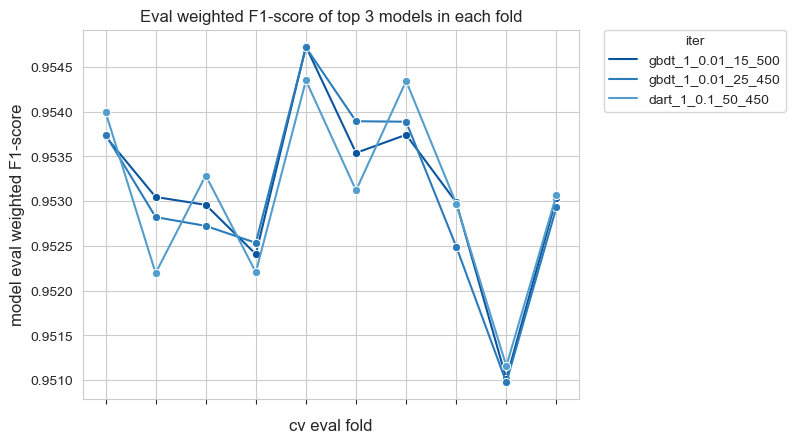

In [34]:
# model scores ordered by performance
model_f1 = df_results.filter(regex=r"split\d*_test_f1_weighted").iloc[:3]

fig, ax = plt.subplots()

sns.lineplot(
    data=model_f1.transpose(),
    dashes=False,
    marker="o",
    ax=ax,
)

ax.set_title('Eval weighted F1-score of top 3 models in each fold')
ax.set_xlabel("cv eval fold", size=12, labelpad=10)
ax.set_ylabel("model eval weighted F1-score", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.legend(title='iter', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [35]:
# correlation of weighted F1-score across folds
print(f"Correlation of models based on weighted F1-score:\n")
model_f1.transpose().corr()

Correlation of models based on weighted F1-score:



iter,gbdt_1_0.01_15_500,gbdt_1_0.01_25_450,dart_1_0.1_50_450
iter,,,
gbdt_1_0.01_15_500,1.000000,0.974509,0.909947
gbdt_1_0.01_25_450,0.974509,1.000000,0.889861
dart_1_0.1_50_450,0.909947,0.889861,1.000000


### Pairwise Comparison of Models

[Frequentist Approach](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html#): Run a paired t-test and compute the p-value.

We observe that the models **don't significantly differ** from each other, thus we can select the proposed model from hyperaparameter tuning.

In [36]:
# pairwise comparison of models based on weighted F1-score

n_train = len(cv[0][0])
n_test = len(cv[0][1])

n_comparisons = factorial(len(model_f1)) / (factorial(2) * factorial(len(model_f1) - 2))
pairwise_t_test = []

for model_i, model_k in combinations(range(len(model_f1)), 2):
    model_i_scores = model_f1.iloc[model_i].values
    model_k_scores = model_f1.iloc[model_k].values
    differences = model_i_scores - model_k_scores
    n = differences.shape[0]  # number of test sets
    df = n - 1
    t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
    p_val *= n_comparisons  # Bonferroni correction
    p_val = 1 if p_val > 1 else p_val  # Bonferroni can output p-values higher than 1
    pairwise_t_test.append([model_f1.index[model_i], model_f1.index[model_k], t_stat, p_val])

pairwise_comp_df = pd.DataFrame(pairwise_t_test, 
                                columns=["model_1", "model_2", "t_stat", "p_val"]).round(3)
pairwise_comp_df

,model_1,model_2,t_stat,p_val
0,gbdt_1_0.01_15_500,gbdt_1_0.01_25_450,0.065,1
1,gbdt_1_0.01_15_500,dart_1_0.1_50_450,0.038,1
2,gbdt_1_0.01_25_450,dart_1_0.1_50_450,0.002,1


### Final Model Evaluation

---

**Best model parameters:** n_estimators: n_estimators: 500, max_depth: 15, learning_rate: 0.01, colsample_bytree: 1.0, booster: 'gbdt'

---

**Best model train weighted F1-score:** 96%
- class paid: 98%
- class defaulted: 53%

**Best model eval weighted F1-score:** 96%
- class paid: 98%
- class defaulted: 52%

---

**Best model train weighted Precision:** 96%
- class paid: 97%
- class defaulted: 90%

**Best model eval weighted Precision:** 96%
- class paid: 97%
- class defaulted: 87%

---

**Best model train weighted Recall:** 97%

**Best model eval weighted Recall:** 97%

---

**Conclusion:** Regarding the defaulted payments, although the model has a high Precision, it grossly underperforms in terms of F1-score. 

In [37]:
X_temp, y_temp, X_eval, y_eval = custom_train_test_split(
    pd.concat([X_train, y_train], axis=1), 
    primary_key="repayment_id", 
    output_key="status_cleaned", 
    split_key="loan_id", 
    test_size=0.2, 
    random_state=42
)

X_temp, X_eval = X_temp.drop(columns=["loan_id"]), X_eval.drop(columns=["loan_id"])

In [ ]:
clf = LGBMClassifier(
    n_estimators=500,
    max_depth=15,
    learning_rate=0.01,
    colsample_bytree=1,
    boosting_type='gbdt',
    random_state=42
)

clf.fit(X_temp, np.ravel(y_temp))

y_train_pred = clf.predict(X_temp)
y_eval_pred = clf.predict(X_eval)

In [41]:
print(f"Train:\n{classification_report(y_temp, y_train_pred, target_names=labels)}")
print(f"Eval:\n{classification_report(y_eval, y_eval_pred, target_names=labels)}")

Train:
              precision    recall  f1-score   support

        paid       0.97      1.00      0.98    106152
   defaulted       0.90      0.37      0.53      5720

    accuracy                           0.97    111872
   macro avg       0.94      0.69      0.76    111872
weighted avg       0.96      0.97      0.96    111872

Eval:
              precision    recall  f1-score   support

        paid       0.97      1.00      0.98     25068
   defaulted       0.87      0.37      0.52      1264

    accuracy                           0.97     26332
   macro avg       0.92      0.68      0.75     26332
weighted avg       0.96      0.97      0.96     26332



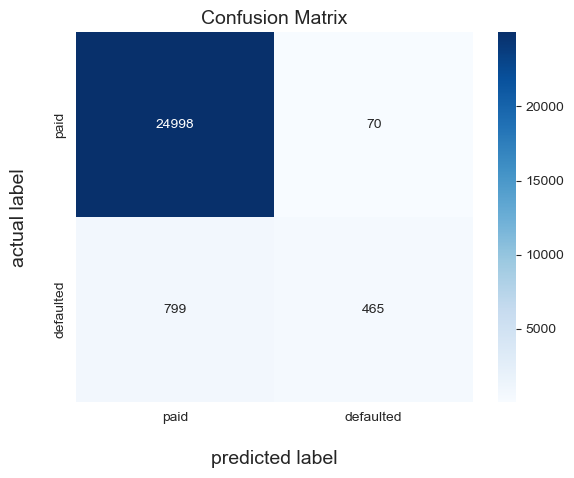

In [42]:
cm = confusion_matrix(y_eval, y_eval_pred)

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix', fontsize=14)
plt.xlabel("\npredicted label", fontsize=14)
plt.ylabel("actual label\n", fontsize=14)

plt.show()

# Final Model

In [29]:
labels = ["paid", "defaulted"]

In [30]:
X_train, X_test = X_train.drop(columns=["loan_id"]), X_test.drop(columns=["loan_id"])

## Final Model

---

**Model:** LightGBM

**Parameters:** n_estimators: 500, max_depth: 15, learning_rate: 0.01, colsample_bytree: 1.0, booster: 'gbdt'

*The final model has been chosen based on the best weighted F1-score, Precision and Recall on the evaluation sample. Also, the degree of overfittng (or underfitting) has been taken into consideration.*

In [ ]:
clf = LGBMClassifier(
    n_estimators=500,
    max_depth=15,
    learning_rate=0.01,
    colsample_bytree=1,
    boosting_type='gbdt',
    random_state=42
)

clf.fit(X_train, np.ravel(y_train))

y_train_pred, y_train_pred_proba = clf.predict(X_train), clf.predict_proba(X_train)
y_test_pred, y_test_pred_proba = clf.predict(X_test), clf.predict_proba(X_test)

## Metrics

---

**Train weighted F1-score:** 96%
- class paid: 98%
- class defaulted: 53%

**Test weighted F1-score:** 95%
- class paid: 98%
- class defaulted: 47%

---

**Train weighted Precision**: 96%
- class paid: 97%
- class defaulted: 90%

**Test weighted Precision:** 96%
- class paid: 96%
- class defaulted: 88%

---

**Train weighted Recall**: 97%

**Test weighted Recall:** 96%

---
**Conclusion:** Regarding the defaulted payments, although the model has a high Precision, it grossly underperforms in terms of F1-score. 

In [32]:
print(f"Train:\n{classification_report(y_train, y_train_pred, target_names=labels)}")
print(f"Test:\n{classification_report(y_test, y_test_pred, target_names=labels)}")

Train:
              precision    recall  f1-score   support

        paid       0.97      1.00      0.98    131220
   defaulted       0.90      0.37      0.53      6984

    accuracy                           0.97    138204
   macro avg       0.94      0.68      0.75    138204
weighted avg       0.96      0.97      0.96    138204

Test:
              precision    recall  f1-score   support

        paid       0.96      1.00      0.98     32485
   defaulted       0.88      0.33      0.47      1756

    accuracy                           0.96     34241
   macro avg       0.92      0.66      0.73     34241
weighted avg       0.96      0.96      0.95     34241



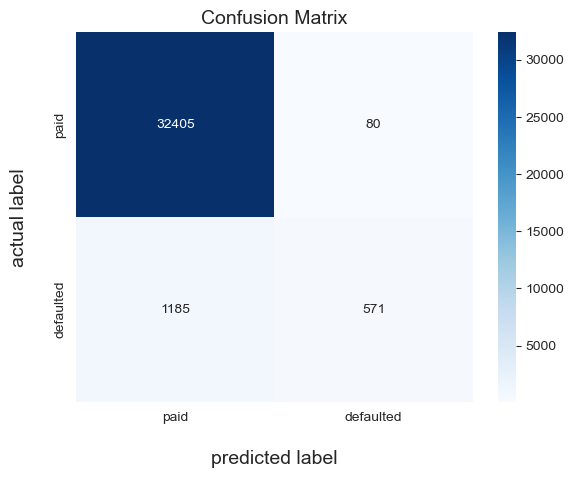

In [33]:
cm = confusion_matrix(y_test, y_test_pred)

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix', fontsize=14)
plt.xlabel("\npredicted label", fontsize=14)
plt.ylabel("actual label\n", fontsize=14)

plt.show()

## Model Analysis

We define clusters (groups) of loan repayments based on important variables for which we need to provide "accurate" prediction (derived by business needs). These clusters (groups) are based on: 
- repayment amount
- loan interest rate
- RFM customer segments
 
For those cluster, we observe the following:
- The model mispredicts for small to medium repayments
- The model equally mispredicts for all RFM customer segments
- The model mainly mispredicts for small loan interest rates

In [111]:
# temp dataframe with test set (1) features, (2) ground truth and (3) prediction
temp_data_test = pd.concat([X_test, y_test], axis=1)
temp_data_test["prediction"] = y_test_pred.tolist()

# aux column marking correct/incorrect predictions
temp_data_test["correct"] = temp_data_test["prediction"] == temp_data_test["status_cleaned"]
temp_data_test["correct"] = temp_data_test["correct"].replace({True: "correct", False: "incorrect"})

temp_data_test = temp_data_test[temp_data_test["status_cleaned"] == 1]

In [120]:
temp_data_test.loc[temp_data_test["repayment_amount"] <= 250, "repayment_amount_bin"] = "small"
temp_data_test.loc[temp_data_test["repayment_amount"].between(250, 500, inclusive="right"), "repayment_amount_bin"] = "small-medium"
temp_data_test.loc[temp_data_test["repayment_amount"].between(500, 1_000, inclusive="right"), "repayment_amount_bin"] = "medium"
temp_data_test.loc[temp_data_test["repayment_amount"].between(1_000, 2_500, inclusive="right"), "repayment_amount_bin"] = "medium-large"
temp_data_test.loc[temp_data_test["repayment_amount"] > 2_500, "repayment_amount_bin"] = "large"

# calculate the percentage of correct/incorrect instances per principal amount bin
df = temp_data_test.groupby(["repayment_amount_bin"], as_index=False)["correct"].value_counts()
aux = df.groupby("repayment_amount_bin", as_index=False)["count"].sum()
df["pct"] = 0
for i in df["repayment_amount_bin"].unique():
    df.loc[df["repayment_amount_bin"] == i, "pct"] = df[df["repayment_amount_bin"] == i]["count"].values / aux[aux["repayment_amount_bin"] == i]["count"].values

fig = px.bar(
    df, 
    y='repayment_amount_bin', 
    x='pct', 
    color="correct",
    orientation="h",
    color_discrete_sequence=[colors["dark_blue"], colors["dark_purple"]]
)

fig.update_layout(
    title_text='<b>The model mispredicts for small to medium/large repayments<br><sub>defaulted repayments only</sub><b>',
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title_text='% of instances',
    yaxis_title_text="repayment amount (R$)",
    legend=dict(
        title=None,
        traceorder="normal",
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1.0
    ),
    template=template
)
fig.update_yaxes(
    categoryorder='array', 
    categoryarray=["small", "small-medium", "medium", "medium-large", "large"]
)
fig.update_traces(
    texttemplate='%{x:,.0%}',
    textposition='inside'
)

fig.show()

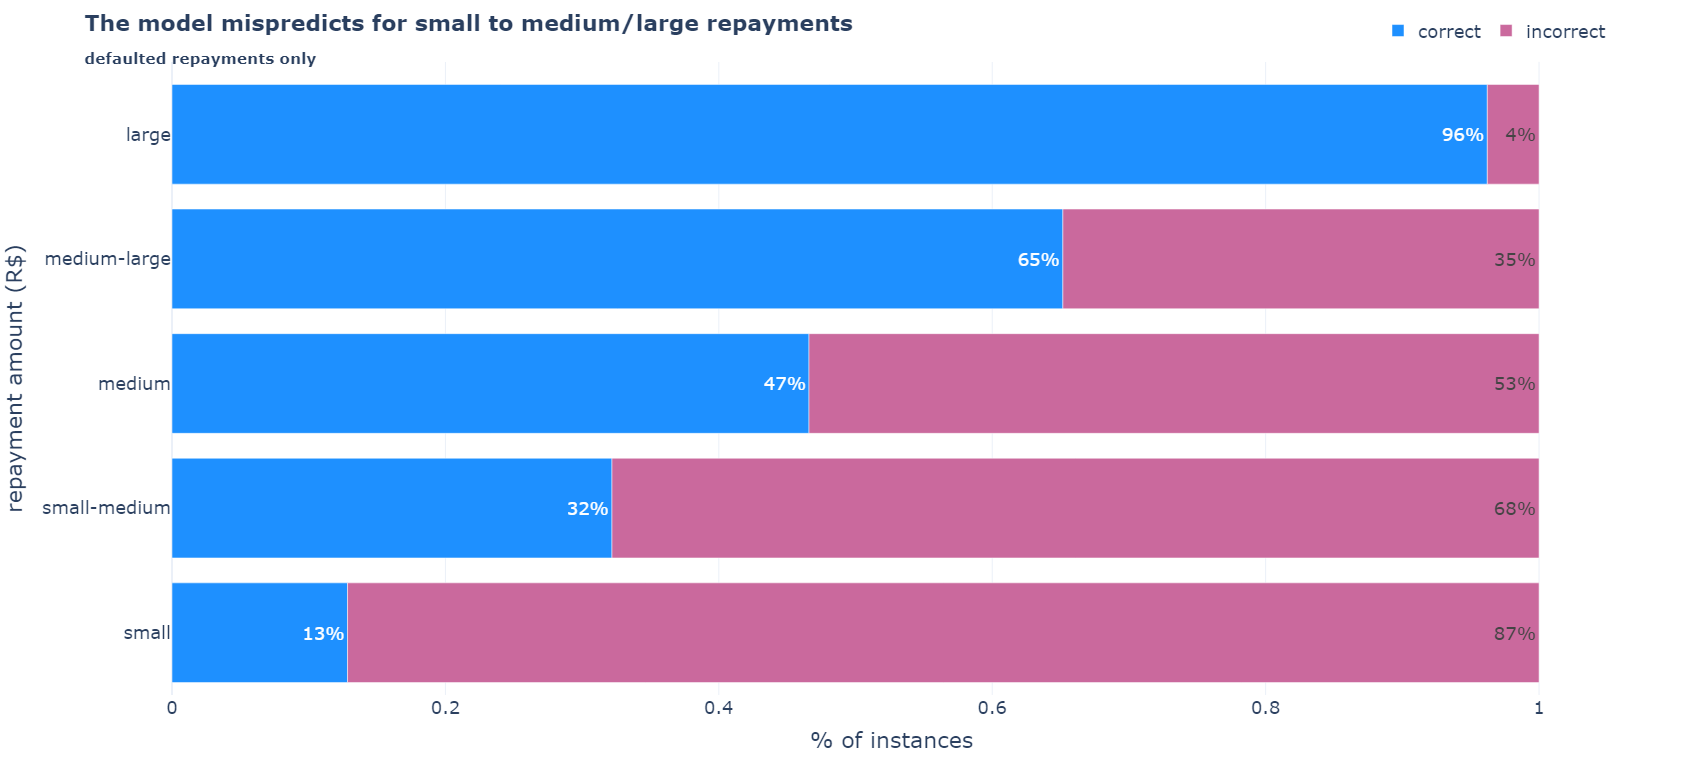

In [123]:
# reverse one-hot encoding
rfm_segments = ["rfm_segment_Big Spenders", "rfm_segment_Champions", "rfm_segment_Inactive", "rfm_segment_Promising", "rfm_segment_Recent"]
temp_data_test["rfm_segments"] = pd.from_dummies(temp_data_test[rfm_segments])
temp_data_test["rfm_segments"] = temp_data_test["rfm_segments"].replace({
    "rfm_segment_Big Spenders": "Big Spenders", 
    "rfm_segment_Champions": "Champions",
    "rfm_segment_Inactive": "Inactive", 
    "rfm_segment_Promising": "Promising", 
    "rfm_segment_Recent": "Recent"
})

# calculate the percentage of correct/incorrect instances per RFM segment
df = temp_data_test.groupby(["rfm_segments"], as_index=False)["correct"].value_counts()
aux = df.groupby("rfm_segments", as_index=False)["count"].sum()
df["pct"] = 0
for i in df["rfm_segments"].unique():
    df.loc[df["rfm_segments"] == i, "pct"] = df[df["rfm_segments"] == i]["count"].values / aux[aux["rfm_segments"] == i]["count"].values

fig = px.bar(
    df, 
    y='rfm_segments', 
    x='pct', 
    color="correct",
    orientation="h",
    color_discrete_sequence=[colors["dark_blue"], colors["dark_purple"]]
)

fig.update_layout(
    title_text='<b>The model equally mispredicts for all RFM customer segments<br><sub>defaulted repayments only</sub><b>',
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title_text='% of instances',
    yaxis_title_text="customer segments",
    legend=dict(
        title=None,
        traceorder="normal",
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1.0
    ),
    template=template
)
fig.update_yaxes(
    categoryorder='array', 
    categoryarray=["Inactive", "Recent", "Promising", "Champions"]
)
fig.update_traces(
    texttemplate='%{x:,.0%}',
    textposition='inside'
)

fig.show()

C:\Users\lampr\AppData\Local\Temp\ipykernel_22112\3637149652.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lampr\AppData\Local\Temp\ipykernel_22112\3637149652.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



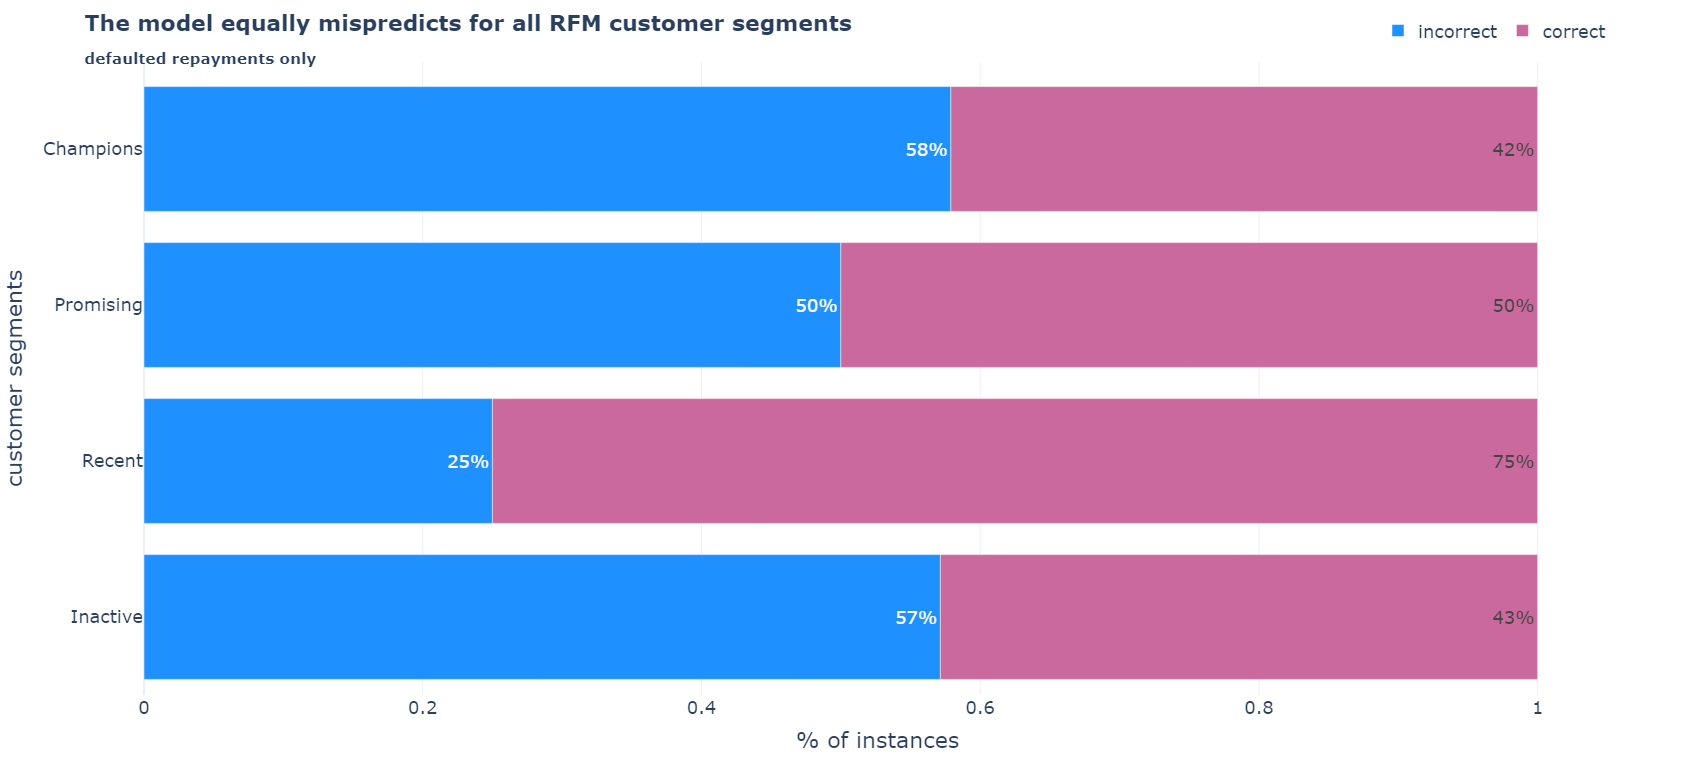

**Note:**
- Big Spenders isn't available at the test set

In [133]:
# reverse one-hot encoding
interest_rate_bin = ["interest_rate_bin_small", "interest_rate_bin_medium", "interest_rate_bin_large"]
temp_data_test["interest_rate_bin"] = pd.from_dummies(temp_data_test[interest_rate_bin])
temp_data_test["interest_rate_bin"] = temp_data_test["interest_rate_bin"].replace({
    "interest_rate_bin_small": "small", 
    "interest_rate_bin_medium": "medium",
    "interest_rate_bin_large": "large", 
})

# calculate the percentage of correct/incorrect instances per interest rate bin
df = temp_data_test.groupby(["interest_rate_bin"], as_index=False)["correct"].value_counts()
aux = df.groupby("interest_rate_bin", as_index=False)["count"].sum()
df["pct"] = 0
for i in df["interest_rate_bin"].unique():
    df.loc[df["interest_rate_bin"] == i, "pct"] = df[df["interest_rate_bin"] == i]["count"].values / aux[aux["interest_rate_bin"] == i]["count"].values

fig = px.bar(
    df, 
    y='interest_rate_bin', 
    x='pct', 
    color="correct",
    orientation="h",
    color_discrete_sequence=[colors["dark_blue"], colors["dark_purple"]]
)

fig.update_layout(
    title_text='<b>The model mainly mispredicts for small loan interest rates<br><sub>defaulted repayments only</sub><b>',
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title_text='% of instances',
    yaxis_title_text="loan intereset rate",
    legend=dict(
        title=None,
        traceorder="normal",
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1.0
    ),
    template=template
)
fig.update_traces(
    texttemplate='%{x:,.0%}',
    textposition='inside'
)

fig.show()

C:\Users\lampr\AppData\Local\Temp\ipykernel_22112\1029443994.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lampr\AppData\Local\Temp\ipykernel_22112\1029443994.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



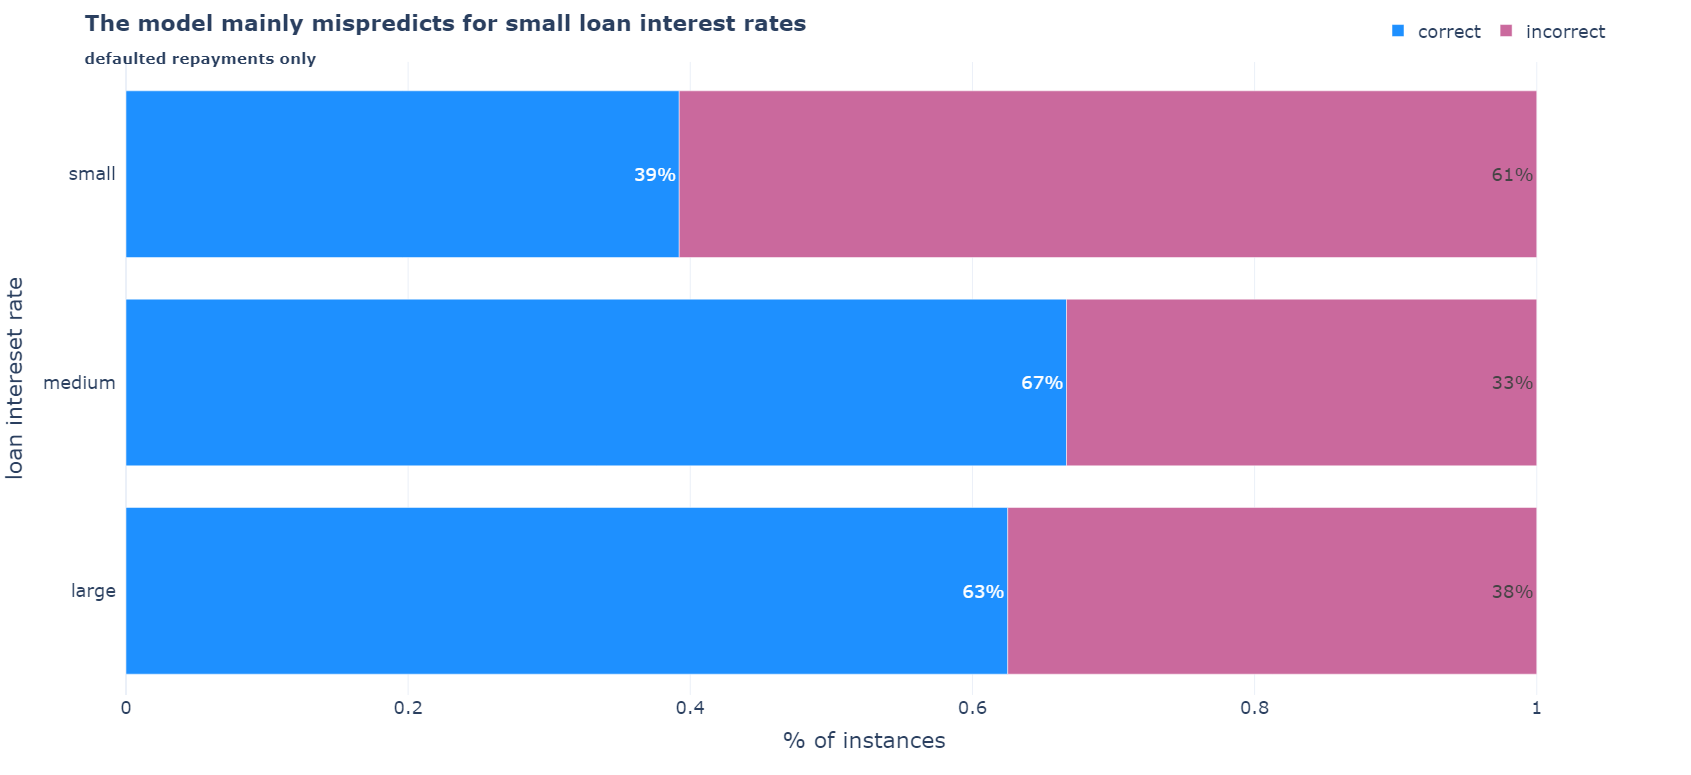

## Feature Importance

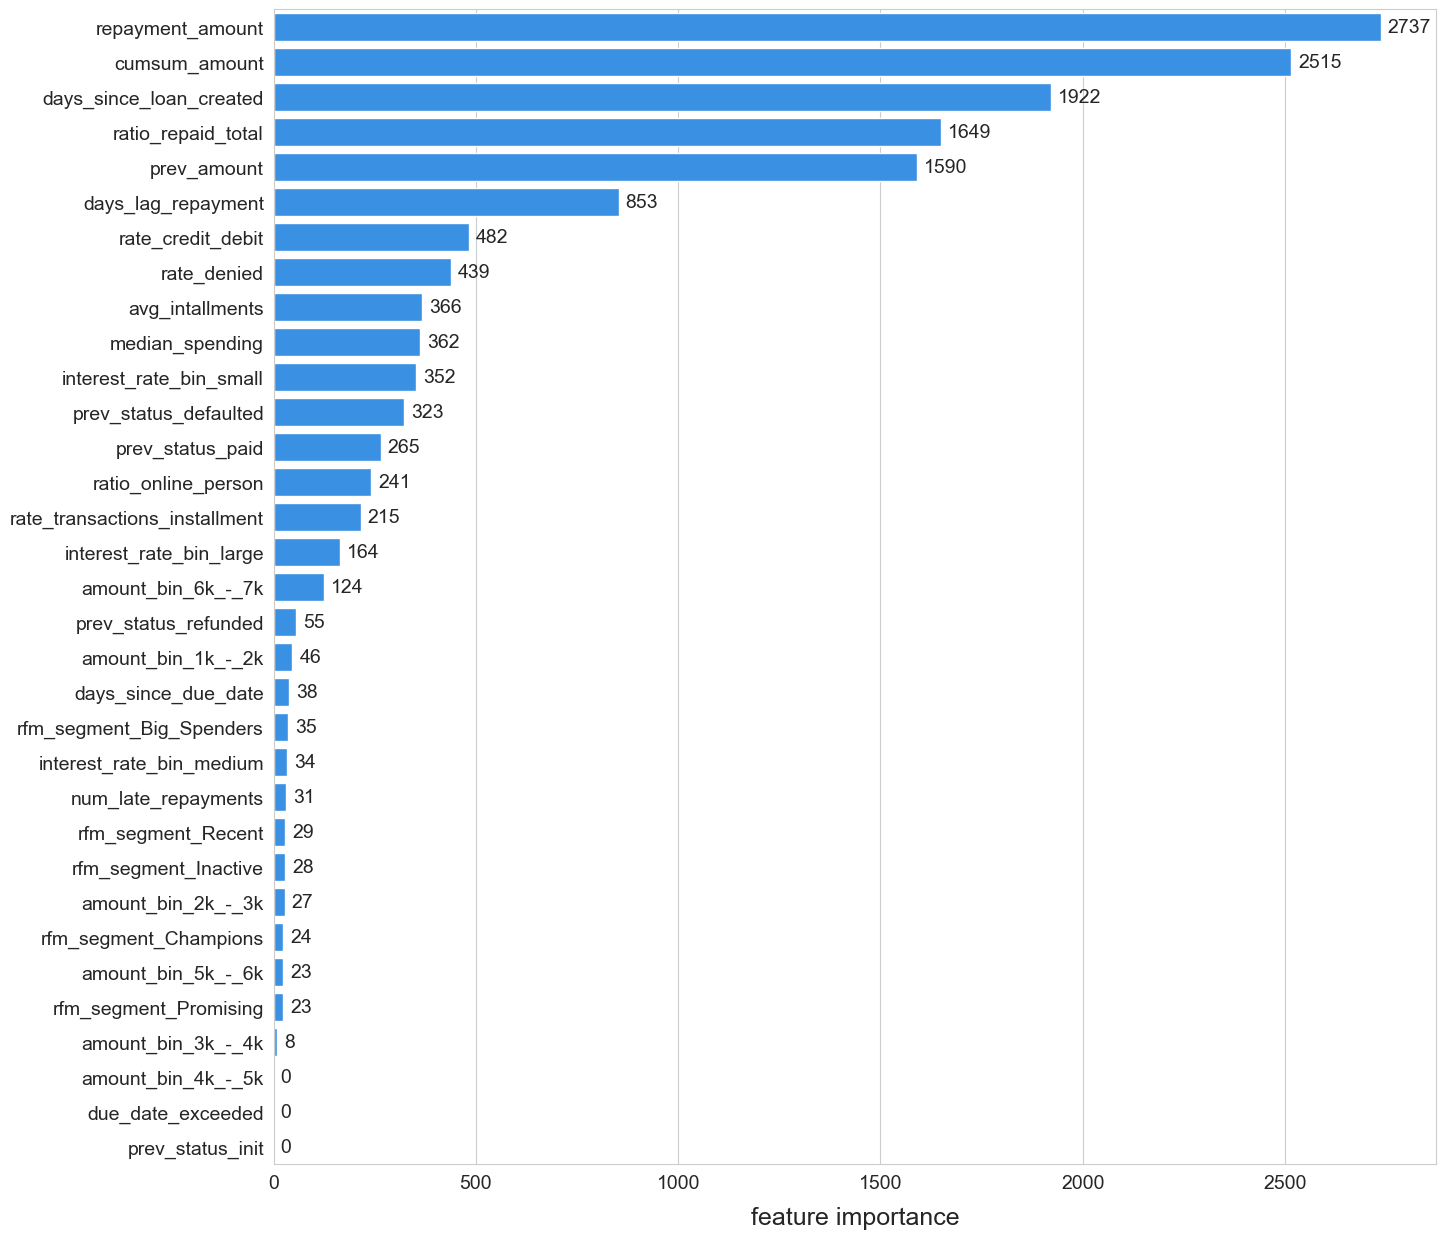

In [110]:
feature_importances = pd.DataFrame(list(zip(clf.feature_name_, clf.feature_importances_)),
                                   columns=['feature', 'importance'])
feature_importances = feature_importances.sort_values(by=['importance'], ascending=False)

fig, ax = plt.subplots(figsize=(15, 15))

sns.barplot(x=feature_importances["importance"], y=feature_importances["feature"], color='#1E90FF')

ax.set_xlabel("feature importance", fontsize=font_size, labelpad=10)
ax.set_ylabel(None)
ax.tick_params(labelsize=14)
ax.bar_label(ax.containers[0], padding=5, fontsize=14)

plt.show()